In [6]:
from datetime import timedelta

from datetime import datetime
from pprint import pprint
import time
import json

from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
import numpy as np
import requests

headers = {
    "User-Agent":
        "Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0"
}

period = {
    "1d": {"intraday": True, "delta": timedelta(days=1)},
    "1w": {"intraday": True, "delta": timedelta(days=7)},
    "1m": {"intraday": False, "delta": timedelta(days=31)},
    "3m": {"intraday": False, "delta": timedelta(days=93)},
    "6m": {"intraday": False, "delta": timedelta(days=186)},
    "1y": {"intraday": False, "delta": timedelta(days=365)},
    "5y": {"intraday": False, "delta": timedelta(days=1825)}
}

chart_type = "area"

In [7]:
def xaxis_modify(timestamp_df):
    return timestamp_df.apply(
        lambda x: datetime.fromtimestamp(int(str(x)[:-3])))


def plot_volume_with_share_price(title, volume_df, share_price_df, figsize=(15, 7)):
    # min-max normalization
    volume_df['volume'] = volume_df['volume'].astype(np.float64)
    vmax = volume_df['volume'].max()
    vmin = volume_df['volume'].min()
    volume_df['volume'] = volume_df['volume'].apply(
        lambda x: (x - vmin) / (vmax - vmin)
    )
    
    share_price_df['share_price'] = share_price_df['share_price'].astype(np.float64)
    vmax = share_price_df['share_price'].max()
    vmin = share_price_df['share_price'].min()
    share_price_df['share_price'] = share_price_df['share_price'].apply(
        lambda x: (x - vmin) / (vmax - vmin)
    )

    plt.figure(figsize=figsize)
    plt.title("%s (normalized)" % title)
    volume_chart = sns.lineplot(x="datetime", y="volume", data=volume_df)
    share_price_chart = sns.lineplot(x="datetime", y="share_price", data=share_price_df)
    volume_chart.legend(["Volume", "Share Price (PLN)"])
    plt.grid()

In [8]:
def download_data(SYMBOL, PERIOD):
    url_intraday = period[PERIOD]["intraday"]
    url_delta = period[PERIOD]["delta"]
    url = "https://www.bankier.pl/new-charts/get-data"
    url_params = {
        "date_from": "%s000" % int((datetime.now()-url_delta).timestamp()),
        "date_to": "%s000" % int(time.time()),
        "symbol": SYMBOL,
        "intraday": "true" if url_intraday else "false",
        "type": chart_type
    }

    url = "%s?%s" % (
        url, "&".join(["%s=%s" % (k, v) for k, v in url_params.items()]))

    response = requests.get(url, headers=headers)
    if not response.ok:
        raise Exception("Response: %s" % response.status_code)
    response_json = json.loads(response.content)

    # Volume
    volume_df = pd.DataFrame(
        np.array(response_json["volume"]),
        columns=["timestamp", "volume"])
    volume_df["timestamp"] = volume_df["timestamp"].astype(np.int64)
    volume_df["datetime"] = xaxis_modify(volume_df["timestamp"])

    # Share price
    share_price_df = pd.DataFrame(
        np.array(response_json["main"]),
        columns=["timestamp", "share_price"])
    share_price_df["timestamp"] = share_price_df["timestamp"].astype(np.int64)
    share_price_df["datetime"] = xaxis_modify(share_price_df["timestamp"])
    
    return volume_df, share_price_df

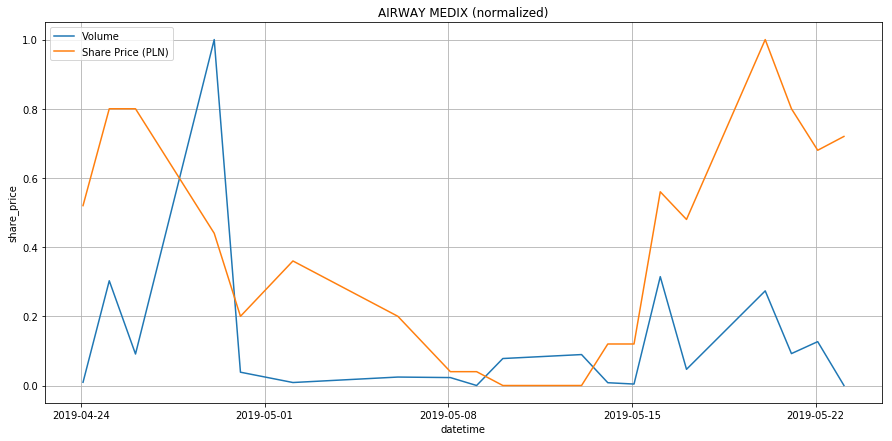

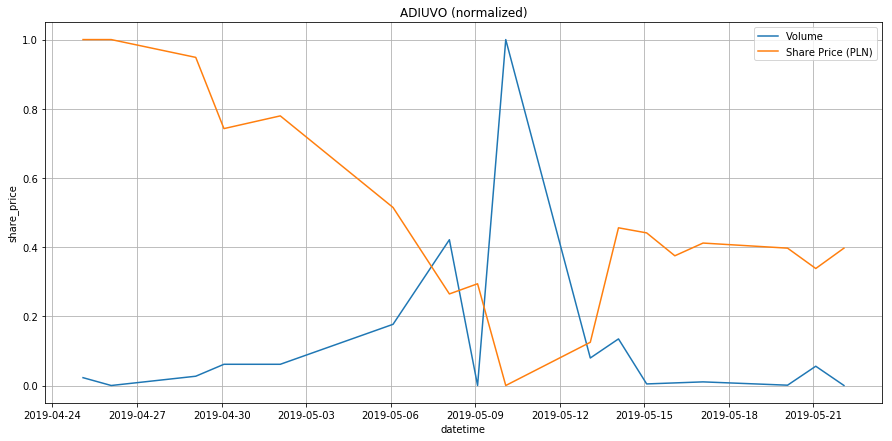

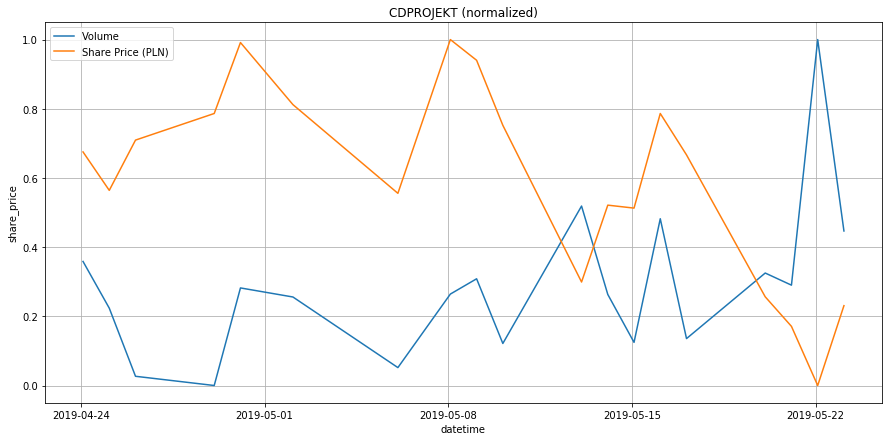

In [9]:
PERIOD = "1m"

volume_df, share_price_df = download_data("AIRWAY", PERIOD)
plot_volume_with_share_price("AIRWAY MEDIX", volume_df, share_price_df)

volume_df, share_price_df = download_data("ADIUVO", PERIOD)
plot_volume_with_share_price("ADIUVO", volume_df, share_price_df)

volume_df, share_price_df = download_data("CDPROJEKT", PERIOD)
plot_volume_with_share_price("CDPROJEKT", volume_df, share_price_df)

plt.show()